In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff
import tensorflow as tf
from tensorflow.python.keras.layers import Dense, Dropout, LSTM
from tensorflow.python.keras import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OrdinalEncoder
from pandas import DataFrame
from pandas import concat
from pickle import dump
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
agg_data = pd.read_csv("clean_data.csv")

In [4]:
agg_data.head()

,Month,DayOfWeek,HourofDay,Day,DateTime,HvacMode,Event,Schedule,T_ctrl,T_stp_heat,...,fan,Thermostat_Temperature,Thermostat_Motion,Remote_Sensor_1_Temperature,Remote_Sensor_1_Motion,T_out,RH_out,Season,timing,Date
0,1,1,0,1,2019-01-01 00:00:00,auxHeatOnly,NaN,Sleep,68.0,59.0,...,0.0,68.0,0.0,68.0,1.0,35.0,97.0,Winter,Night,2019-01-01
1,1,1,0,1,2019-01-01 00:05:00,auxHeatOnly,NaN,Sleep,68.0,59.0,...,0.0,68.0,0.0,68.0,0.0,35.0,97.0,Winter,Night,2019-01-01
2,1,1,0,1,2019-01-01 00:10:00,auxHeatOnly,NaN,Sleep,68.0,59.0,...,0.0,68.0,1.0,68.0,1.0,35.0,97.0,Winter,Night,2019-01-01
3,1,1,0,1,2019-01-01 00:15:00,auxHeatOnly,NaN,Sleep,68.0,59.0,...,0.0,68.0,0.0,68.0,1.0,35.0,97.0,Winter,Night,2019-01-01
4,1,1,0,1,2019-01-01 00:20:00,auxHeatOnly,NaN,Sleep,68.0,59.0,...,0.0,68.0,0.0,68.0,1.0,35.0,97.0,Winter,Night,2019-01-01


In [5]:
agg_df = agg_data[['DateTime','Month','DayOfWeek','HourofDay','Day','T_ctrl', 'T_stp_heat', 'T_out', 'RH_out','Humidity','fan','auxHeat1']]

In [6]:
agg_df.auxHeat1.value_counts().index

Float64Index([  0.0, 300.0, 270.0,  90.0, 225.0, 180.0,  30.0, 105.0, 285.0,
               15.0,  45.0, 120.0, 165.0, 255.0, 150.0, 240.0,  75.0, 135.0,
              195.0,  60.0, 210.0],
             dtype='float64')

In [7]:
agg_df.auxHeat1.value_counts().values

array([177151,  45688,   1406,   1366,   1364,   1360,   1353,   1349,
         1346,   1344,   1337,   1329,   1314,   1310,   1310,   1309,
         1306,   1296,   1293,   1292,   1292])

In [8]:
agg_df.HourofDay.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [9]:
house_df_final=agg_df.copy()
house_df_final

,DateTime,Month,DayOfWeek,HourofDay,Day,T_ctrl,T_stp_heat,T_out,RH_out,Humidity,fan,auxHeat1
0,2019-01-01 00:00:00,1,1,0,1,68.0,59.0,35.0,97.0,40.0,0.0,0.0
1,2019-01-01 00:05:00,1,1,0,1,68.0,59.0,35.0,97.0,40.0,0.0,0.0
2,2019-01-01 00:10:00,1,1,0,1,68.0,59.0,35.0,97.0,40.0,0.0,0.0
3,2019-01-01 00:15:00,1,1,0,1,68.0,59.0,35.0,97.0,41.0,0.0,0.0
4,2019-01-01 00:20:00,1,1,0,1,68.0,59.0,35.0,97.0,41.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
248113,2019-04-30 23:35:00,4,1,23,30,73.0,68.0,55.0,30.0,53.0,0.0,0.0
248114,2019-04-30 23:40:00,4,1,23,30,73.0,68.0,55.0,30.0,53.0,0.0,0.0
248115,2019-04-30 23:45:00,4,1,23,30,73.0,68.0,55.0,30.0,53.0,0.0,0.0
248116,2019-04-30 23:50:00,4,1,23,30,73.0,68.0,55.0,30.0,53.0,0.0,0.0


In [10]:
grouped_multiple = agg_df.groupby(['Month', 'Day','HourofDay']).agg({'T_ctrl':'mean','T_stp_heat':'mean','T_out':'mean','RH_out':'mean','Humidity':'mean','fan':'mean','auxHeat1':sum})
grouped_multiple.columns = ['T_ctrl','T_stp_heat','T_out','RH_out','Humidity','fan','auxHeat1']
grouped_multiple = grouped_multiple.reset_index()
print(grouped_multiple)

      Month  Day  HourofDay     T_ctrl  T_stp_heat      T_out     RH_out  \
0         1    1          0  69.016667   65.600000  33.300000  93.000000   
1         1    1          1  68.566667   65.600000  33.400000  91.800000   
2         1    1          2  68.166667   65.600000  32.900000  89.400000   
3         1    1          3  68.000000   65.600000  31.100000  87.000000   
4         1    1          4  67.866667   65.616667  29.800000  83.600000   
...     ...  ...        ...        ...         ...        ...        ...   
4936     12   31         19  69.902778   67.861111  31.250000  80.833333   
4937     12   31         20  70.180556   67.833333  30.416667  81.500000   
4938     12   31         21  69.666667   67.791667  29.500000  78.250000   
4939     12   31         22  69.708333   66.805556  30.000000  75.500000   
4940     12   31         23  69.555556   65.583333  30.333333  73.416667   

       Humidity         fan  auxHeat1  
0     38.466667   60.000000     960.0  
1     3

In [11]:
type(grouped_multiple)

pandas.core.frame.DataFrame

In [12]:
house_df_new= grouped_multiple[grouped_multiple['auxHeat1'] != 0.0]

In [13]:
house_df_new['Month']

0        1
1        1
2        1
3        1
4        1
        ..
4936    12
4937    12
4938    12
4939    12
4940    12
Name: Month, Length: 4431, dtype: int64

In [15]:
house_df_new.to_csv("agg_data.csv", index = False)

In [ ]:
# focussed displots 
f, ax = plt.subplots(3,2,figsize=(12,10))
vis1 = sns.distplot(house_df_new["RH_out"],bins=10, ax= ax[0][0])
vis2 = sns.distplot(house_df_new["T_ctrl"],bins=10, ax=ax[0][1])
vis3 = sns.distplot(house_df_new["auxHeat1"],bins=10, ax=ax[1][0])
vis4 = sns.distplot(house_df_new["Humidity"],bins=10, ax=ax[1][1])
vis5 = sns.distplot(house_df_new["T_stp_heat"],bins=10, ax=ax[2][0])
vis5 = sns.distplot(house_df_new["T_out"],bins=10, ax=ax[2][1])

In [174]:
house_df_new=house_df_new[['T_ctrl','T_stp_heat','T_out','RH_out','Humidity','fan','auxHeat1']]

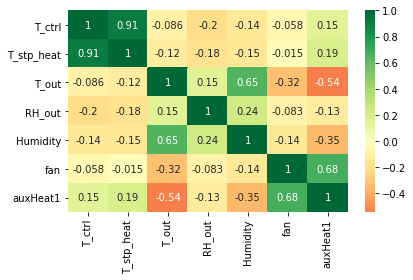

In [175]:
b = sns.heatmap(house_df_new.corr(), xticklabels=house_df_new.corr().columns, yticklabels=house_df_new.corr().columns, cmap='RdYlGn', center=0, annot=True)
#b.title = "Corr"

plt.tight_layout()
#plt.show()

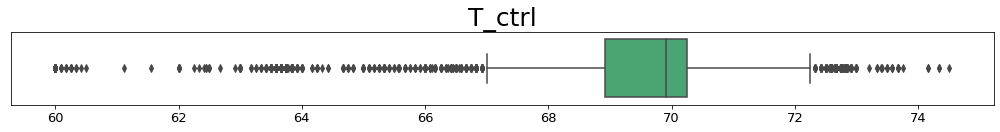

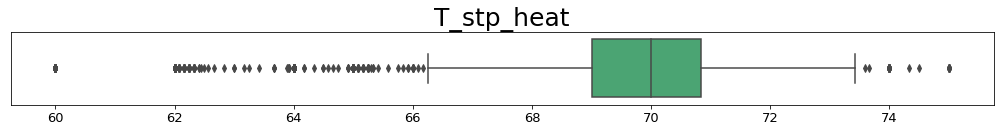

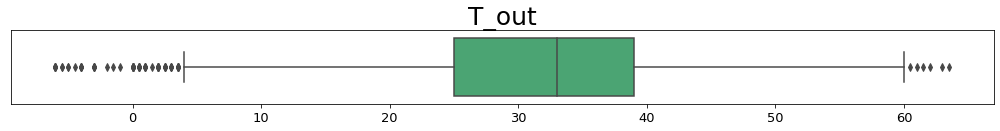

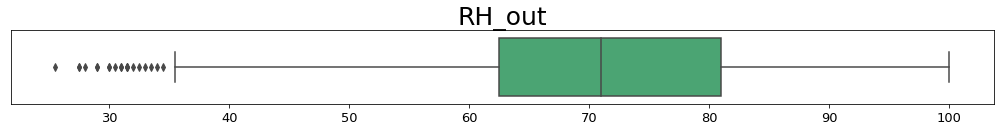

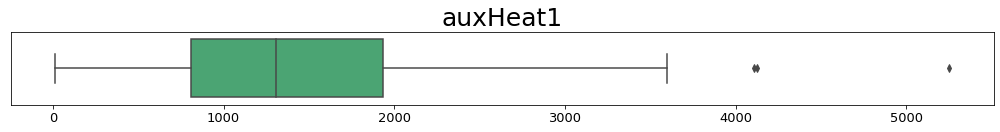

In [176]:
plots = ['T_ctrl','T_stp_heat','T_out','RH_out', 'auxHeat1']
for i in plots:
    plt.figure(figsize = (14, 6))
    plt.subplot(411)
    b = sns.boxplot(house_df_new[i], color='mediumseagreen')
    b.axes.set_title(i,fontsize=25)
    b.set(xlabel=None)
    b.set(yticks=[])
    b.tick_params(labelsize=13)

    plt.tight_layout()

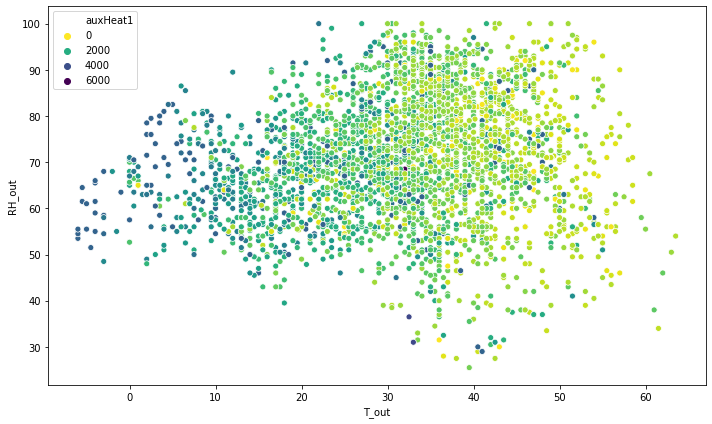

In [177]:
plt.figure(figsize=(10,6))
b = sns.scatterplot(x = 'T_out', y = 'RH_out', 
                    data = house_df_new, hue = 'auxHeat1', palette='viridis_r');

# b.axes.set_title("Ad clicked - Time Spend/Internet Usage",fontsize=25)
# b.set_xlabel("Daily Time Spent On Site",fontsize=18)
# b.set_ylabel("Daily Internet Usage",fontsize=18)
# b.tick_params(labelsize=13)

plt.tight_layout()

[Text(0.5, 0, 'Target Variable Values')]

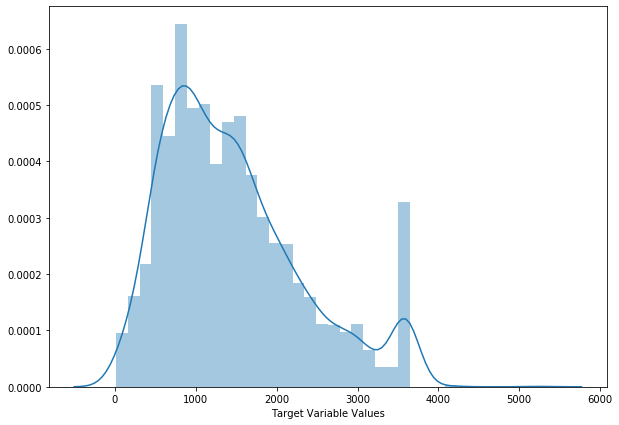

In [178]:
plt.figure(figsize = (10, 7))
ax = sns.distplot(house_df_new.auxHeat1)
ax.set(xlabel = 'Target Variable Values')